In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=9d882697c1097ef926a5cac94019ff680194b681baecdb43ec99d8c250c17a1a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [3]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.1 MB/s eta 0:00:00


In [4]:
import numpy as np
import cv2
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

In [5]:
import zipfile
import os

# Path to the uploaded ZIP file
zip_file_path = "/content/drive/MyDrive/DR_fundus_dataset.zip"
extracted_path = "fundus_image"

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print(f"Dataset extracted to {extracted_path}")

Dataset extracted to fundus_image


In [6]:
file_path = '/content/fundus_image/DR_fundus_dataset/merged_labels.csv'
df = pd.read_csv(file_path)

In [7]:
folder_path = '/content/fundus_image/DR_fundus_dataset/train_images'
image_pattern = '*.png'
image_files = glob.glob(os.path.join(folder_path, image_pattern))

(2136, 3216, 3)


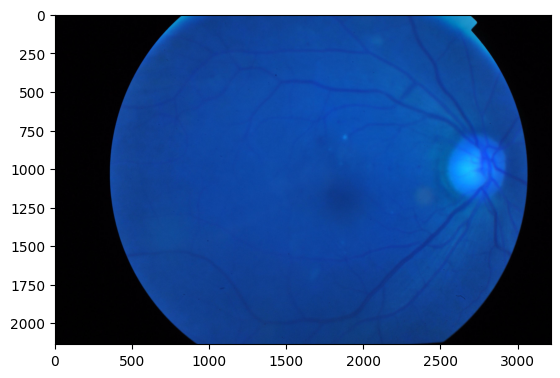

In [8]:
img = cv2.imread('/content/fundus_image/DR_fundus_dataset/train_images/1ae8c165fd53.png')
print(img.shape)
plt.imshow(img)

In [9]:
data = []
labels = []

image_size=(128,128)
for index, row in df.iterrows():
    image_path = f"/content/fundus_image/DR_fundus_dataset/train_images/{row['id_code']}.png"
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    data.append(image)
    labels.append(row['diagnosis'])

In [10]:
X_train = np.array(data)
X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
y_train = np.array(labels, dtype=np.int32)

print(X_train.shape)
print(y_train.shape)

(3662, 128, 128, 3)
(3662,)


In [11]:
print(y_train)

[2 1 4 ... 2 0 2]


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from torch_geometric.nn import GATConv
from sklearn.model_selection import train_test_split
import numpy as np
from torchvision import models

In [13]:
X_train = np.array(data)
y_train = np.array(labels, dtype=np.int32)

X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)  # Adjust test_size as needed
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [14]:
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert image to PyTorch tensor
        image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1) / 255.0  # Normalize to [0, 1]
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [15]:
train_dataset = DiabeticRetinopathyDataset(X_train, y_train)
val_dataset = DiabeticRetinopathyDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [16]:
class DenseNetGCN(nn.Module):
    def __init__(self, num_classes, gat_hidden_dim=128):
        super(DenseNetGCN, self).__init__()

        # DenseNet Backbone
        self.densenet = models.densenet121(pretrained=True)  # Pretrained DenseNet
        self.feature_extractor = nn.Sequential(
            self.densenet.features,  # Extract feature maps
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((7, 7))  # Uniform spatial resolution
        )
        feature_dim = 1024  # DenseNet-121's feature dimension

        # GCN Layers
        self.gat1 = GATConv(feature_dim, gat_hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(gat_hidden_dim * 4, gat_hidden_dim, heads=4, concat=True)

        # Classification Head
        self.fc = nn.Sequential(
            nn.Linear(gat_hidden_dim * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, edge_index):
        # Extract features using DenseNet
        features = self.feature_extractor(x)  # Output: [B, 1024, 7, 7]

        # Flatten spatial dimensions into graph nodes
        batch_size, feature_dim, height, width = features.size()
        features_flat = features.view(batch_size, feature_dim, -1).permute(0, 2, 1).reshape(-1, feature_dim)  # [B*7*7, 1024]

        # Create Edge Index for GCN
        num_nodes = height * width
        batch_edge_index = []
        for batch in range(batch_size):
            base_idx = batch * num_nodes
            edges = torch.combinations(torch.arange(num_nodes), r=2).t() + base_idx
            batch_edge_index.append(edges)
        edge_index = torch.cat(batch_edge_index, dim=1).to(features_flat.device)

        # Apply GCN
        x = self.gat1(features_flat, edge_index)
        x = self.gat2(x, edge_index)

        # Global pooling across nodes (mean pooling)
        x = x.view(batch_size, -1, x.size(1)).mean(dim=1)  # Output: [B, 512]

        # Classification
        out = self.fc(x)
        return out

In [17]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, None)  # No edge_index needed as it's created inside the model
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images, None)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

In [22]:
num_classes = len(np.unique(y_train))
model = DenseNetGCN(num_classes=num_classes)
train_model(model, train_loader, val_loader, num_epochs=40)

Epoch 1/40, Loss: 0.7538, Train Accuracy: 0.7258
Validation Loss: 0.6141, Validation Accuracy: 0.7705
Epoch 2/40, Loss: 0.5041, Train Accuracy: 0.8051
Validation Loss: 0.5668, Validation Accuracy: 0.8005
Epoch 3/40, Loss: 0.3439, Train Accuracy: 0.8692
Validation Loss: 0.6654, Validation Accuracy: 0.7978
Epoch 4/40, Loss: 0.2246, Train Accuracy: 0.9259
Validation Loss: 0.7612, Validation Accuracy: 0.7842
Epoch 5/40, Loss: 0.1625, Train Accuracy: 0.9447
Validation Loss: 0.7081, Validation Accuracy: 0.8005
Epoch 6/40, Loss: 0.1338, Train Accuracy: 0.9573
Validation Loss: 0.7133, Validation Accuracy: 0.7978
Epoch 7/40, Loss: 0.1146, Train Accuracy: 0.9645
Validation Loss: 0.7200, Validation Accuracy: 0.8060
Epoch 8/40, Loss: 0.0802, Train Accuracy: 0.9723
Validation Loss: 0.8508, Validation Accuracy: 0.8251
Epoch 9/40, Loss: 0.0739, Train Accuracy: 0.9751
Validation Loss: 0.8746, Validation Accuracy: 0.7814
Epoch 10/40, Loss: 0.0629, Train Accuracy: 0.9764
Validation Loss: 0.8811, Validat

In [23]:
print(len(train_dataset))
print(len(val_dataset))

2929
366


In [24]:
class TestDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1) / 255.0
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [25]:
test_dataset = TestDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [26]:
print(len(test_dataset))

367


Accuracy: 0.8011

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.98       181
     Class 1       0.60      0.57      0.58        37
     Class 2       0.73      0.73      0.73       100
     Class 3       0.41      0.58      0.48        19
     Class 4       0.52      0.37      0.43        30

    accuracy                           0.80       367
   macro avg       0.65      0.65      0.64       367
weighted avg       0.80      0.80      0.80       367



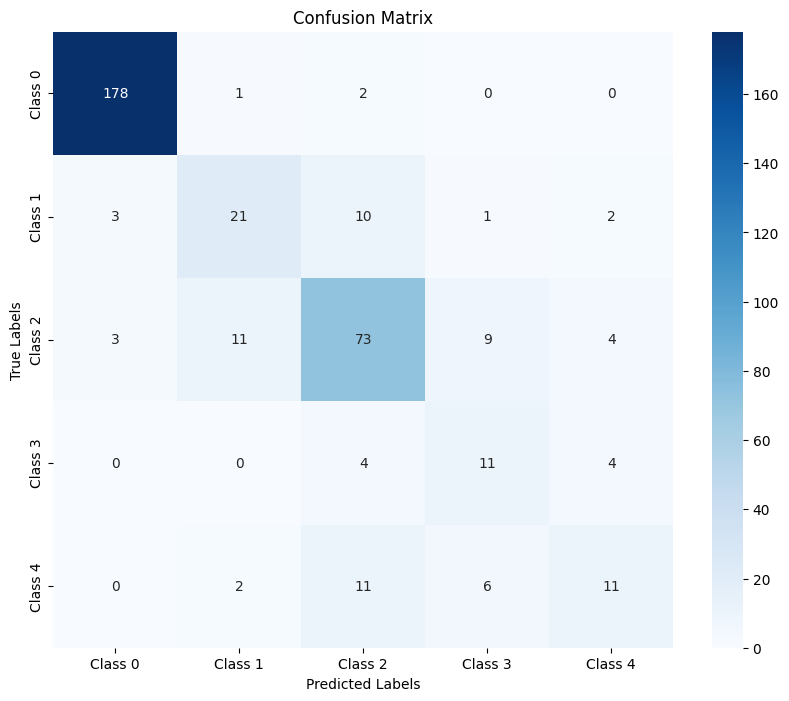

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def test_model_with_metrics(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    # Storage for true labels and predictions
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images, None)  # Edge index is handled inside the model
            _, preds = torch.max(outputs, 1)

            # Store labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate metrics
    accuracy = (np.array(all_labels) == np.array(all_preds)).mean()
    report = classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(len(set(all_labels)))])
    cm = confusion_matrix(all_labels, all_preds)

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[f"Class {i}" for i in range(len(set(all_labels)))], yticklabels=[f"Class {i}" for i in range(len(set(all_labels)))])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, report, cm

# Run the test function
test_accuracy, test_report, test_cm = test_model_with_metrics(model, test_loader)


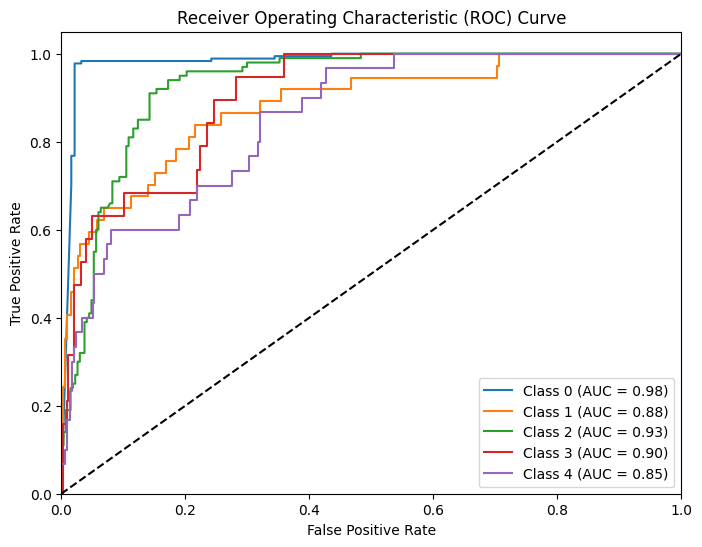

In [28]:
# prompt: auc and roc

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def test_model_with_roc(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images, None)
            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate ROC curve and AUC for each class
    num_classes = len(set(all_labels))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        binary_labels = [1 if label == i else 0 for label in all_labels]
        binary_probs = [prob[i] for prob in all_probs]
        fpr[i], tpr[i], _ = roc_curve(binary_labels, binary_probs)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Call the function to generate ROC curves
test_model_with_roc(model, test_loader)